In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform for the DataLoader used for visualization (with normalization)
transform_visualize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])


In [6]:
# Download and load the MNIST dataset
dataset_path = './MNIST_data'
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# You can adjust the batch size and other parameters as needed
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataset_path, train=True, download=True, transform=transform_visualize),
    batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.0MB/s]


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define AlexNet for MNIST
class AlexNetMNIST(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetMNIST, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# Hyperparams
learning_rate = 0.001
epsilon = 0.03

# Model, loss, optimizer
global_model = AlexNetMNIST().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)

# Directory to save perturbed images
perturbed_dir = "perturbed_images"
os.makedirs(perturbed_dir, exist_ok=True)

# DeepFool attack (batch version)
def deepfool_attack_batch(images, model, epsilon):
    model.eval()
    perturbed_images = images.clone().detach().requires_grad_(True).to(device)

    with torch.no_grad():
        outputs = model(images)
        original_labels = torch.argmax(outputs, dim=1)

    outputs_grad = None
    while True:
        outputs = model(perturbed_images)
        predicted_labels = torch.argmax(outputs, dim=1)

        if torch.all(predicted_labels == original_labels):
            break

        if perturbed_images.grad is not None:
            perturbed_images.grad.data.zero_()

        loss = criterion(outputs, original_labels)
        loss.backward(retain_graph=True)

        if perturbed_images.grad is not None and outputs_grad is None:
            outputs_grad = perturbed_images.grad.data.clone()

        if outputs_grad is not None:
            perturbation = torch.abs(loss) / torch.norm(outputs_grad.view(images.size(0), -1), dim=1).view(-1, 1, 1, 1)
            perturbed_images = perturbed_images + perturbation * outputs_grad / torch.norm(outputs_grad.view(images.size(0), -1), dim=1).view(-1, 1, 1, 1)
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = perturbed_images.clone().detach().requires_grad_(True).to(device)
        else:
            raise ValueError("No gradient computed for perturbed_images.")

    return perturbed_images.detach()

# Save failed image indices
failed_log_path = "failed_images.txt"
with open(failed_log_path, "w") as fail_log:
    fail_log.write("")

# Go through the dataset
total_images = len(train_loader.dataset)
num_batches = (total_images + batch_size - 1) // batch_size

for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    try:
        perturbed_images = deepfool_attack_batch(images, global_model, epsilon)
    except Exception as e:
        print(f"Batch {batch_idx} failed during DeepFool attack: {e}")
        with open(failed_log_path, "a") as f:
            f.write(f"Batch {batch_idx} failed during attack\n")
        continue

    for j in range(len(images)):
        try:
            # Save perturbed image
            class_label = labels[j].item()
            class_subdir = os.path.join(perturbed_dir, str(class_label))
            os.makedirs(class_subdir, exist_ok=True)

            perturbed_image_np = perturbed_images[j].squeeze().detach().cpu().numpy()
            perturbed_image_np = (perturbed_image_np * 255).astype(np.uint8)
            image_path = os.path.join(class_subdir, f"perturbed_{batch_idx * len(images) + j}.jpg")

            if perturbed_image_np.ndim == 2:
                cv2.imwrite(image_path, perturbed_image_np)
            else:
                cv2.imwrite(image_path, np.transpose(perturbed_image_np, (1, 2, 0)))

        except Exception as e:
            print(f"Failed to save image {batch_idx * len(images) + j}: {e}")
            with open(failed_log_path, "a") as f:
                f.write(f"Failed to save image {batch_idx * len(images) + j}: {e}\n")
            continue


In [9]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt

# ========== SETUP ==========
random_seed = 42
torch.manual_seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to checkpoints
drive_path = "/content/drive/MyDrive/my_project_checkpoints"
os.makedirs(drive_path, exist_ok=True)
checkpoint_path = os.path.join(drive_path, "fed_model_checkpoint.pth")
epoch_file_path = os.path.join(drive_path, "last_epoch.txt")
log_file_path = os.path.join(drive_path, "federated_failed_log.txt")

with open(log_file_path, "w") as log_file:
    log_file.write("Failed operations log:\n")

# Image transforms
perturbed_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
perturbed_dataset_path = "./perturbed_images/"

# ========== MODEL ==========
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=105):
        super(GoogLeNet, self).__init__()
        self.model = googlenet(pretrained=True)
        self.model.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.model(x)

global_model = GoogLeNet().to(device)
if torch.cuda.device_count() > 1:
    global_model = nn.DataParallel(global_model)

# ========== HYPERPARAMS ==========
num_clients = 4
fraction = 0.2
num_epochs = 17
learning_rate = 0.001

optimizer = optim.Adam(global_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Dataset split
full_dataset = ImageFolder(perturbed_dataset_path, transform=perturbed_transform)
num_samples = len(full_dataset)
num_train = int(num_samples * (1 - fraction))
train_dataset, test_dataset = random_split(full_dataset, [num_train, num_samples - num_train])

# Client splits
client_datasets = []
indices = list(range(len(train_dataset)))
random.shuffle(indices)
split_size = len(indices) // num_clients
for i in range(num_clients):
    start = i * split_size
    end = None if i == num_clients - 1 else (i + 1) * split_size
    client_datasets.append(Subset(train_dataset, indices[start:end]))

# ========== TRAIN LOCAL ==========
def train_local_model(model, train_loader, optimizer, criterion, device, client_id):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        try:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        except Exception as e:
            with open(log_file_path, "a") as log_file:
                log_file.write(f"[Client {client_id}, Batch {batch_idx}] Error: {e}\n")
            continue

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    return model.state_dict(), train_loss, train_accuracy

# ========== AGGREGATE ==========
def aggregate_models(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([local_models[i][key].float() for i in range(len(local_models))], dim=0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model

# ========== RESUME CHECK ==========
start_epoch = 0
if os.path.exists(checkpoint_path) and os.path.exists(epoch_file_path):
    print("Loading checkpoint to resume training...")
    global_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    with open(epoch_file_path, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming from epoch {start_epoch + 1}")

# ========== FEDERATED TRAINING LOOP ==========
train_losses_plot, train_accuracies_plot = [], []
test_losses_plot, test_accuracies_plot = [], []

for epoch in range(start_epoch, num_epochs):
    local_models, train_losses, train_accuracies = [], [], []

    for client_id, client_dataset in enumerate(client_datasets):
        train_loader = DataLoader(client_dataset, batch_size=32, shuffle=True)
        local_model = GoogLeNet().to(device)
        if torch.cuda.device_count() > 1:
            local_model = nn.DataParallel(local_model)

        local_model.load_state_dict(global_model.state_dict())
        local_optimizer = optim.Adam(local_model.parameters(), lr=learning_rate)
        local_scheduler = optim.lr_scheduler.StepLR(local_optimizer, step_size=30, gamma=0.1)

        try:
            local_dict, train_loss, train_acc = train_local_model(local_model, train_loader, local_optimizer, criterion, device, client_id)
            local_models.append(local_dict)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            local_scheduler.step()
        except Exception as e:
            with open(log_file_path, "a") as log_file:
                log_file.write(f"[Client {client_id}] Local training failed: {e}\n")
            continue

    try:
        global_model = aggregate_models(global_model, local_models)
    except Exception as e:
        with open(log_file_path, "a") as log_file:
            log_file.write(f"[Epoch {epoch+1}] Aggregation failed: {e}\n")
        continue

    # Evaluation
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    global_model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            try:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
            except Exception as e:
                with open(log_file_path, "a") as log_file:
                    log_file.write(f"[Test, Batch {batch_idx}] Error: {e}\n")
                continue

    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_total * 100

    train_losses_plot.append(sum(train_losses) / len(train_losses) if train_losses else 0)
    train_accuracies_plot.append(sum(train_accuracies) / len(train_accuracies) if train_accuracies else 0)
    test_losses_plot.append(test_loss)
    test_accuracies_plot.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_losses_plot[-1]:.4f} |  Train Acc: {train_accuracies_plot[-1]:.2f}%")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_accuracy:.2f}%\n")

    # ========== SAVE CHECKPOINT ==========
    torch.save(global_model.state_dict(), checkpoint_path)
    with open(epoch_file_path, 'w') as f:
        f.write(str(epoch + 1))
    print(f"Checkpoint saved at epoch {epoch+1} ✅\n")


Epoch [1/17]
Train Loss: 0.8218 |  Train Acc: 73.82%
Test  Loss: 1.3540 | Test  Acc: 61.84%

Checkpoint saved at epoch 1 ✅

Epoch [2/17]
Train Loss: 0.6277 |  Train Acc: 79.31%
Test  Loss: 0.4341 | Test  Acc: 85.92%

Checkpoint saved at epoch 2 ✅

Epoch [3/17]
Train Loss: 0.5529 |  Train Acc: 81.83%
Test  Loss: 0.3757 | Test  Acc: 87.04%

Checkpoint saved at epoch 3 ✅

Epoch [4/17]
Train Loss: 0.5051 |  Train Acc: 83.40%
Test  Loss: 0.3518 | Test  Acc: 88.57%

Checkpoint saved at epoch 4 ✅

Epoch [5/17]
Train Loss: 0.4703 |  Train Acc: 84.42%
Test  Loss: 0.3283 | Test  Acc: 88.88%

Checkpoint saved at epoch 5 ✅

Epoch [6/17]
Train Loss: 0.4499 |  Train Acc: 84.96%
Test  Loss: 0.3185 | Test  Acc: 89.48%

Checkpoint saved at epoch 6 ✅

Epoch [7/17]
Train Loss: 0.4259 |  Train Acc: 85.84%
Test  Loss: 0.3065 | Test  Acc: 89.66%

Checkpoint saved at epoch 7 ✅

Epoch [8/17]
Train Loss: 0.4078 |  Train Acc: 86.32%
Test  Loss: 0.2876 | Test  Acc: 90.12%

Checkpoint saved at epoch 8 ✅

Epoch [9

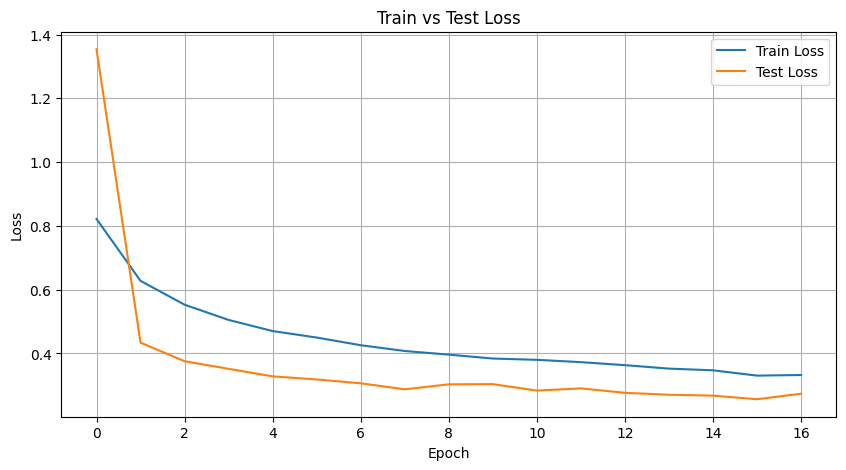

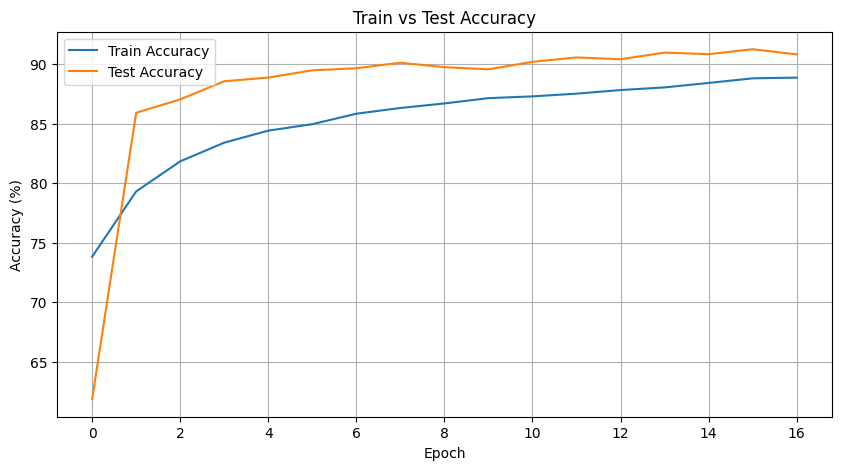

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_plot, label='Train Loss')
plt.plot(test_losses_plot, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_plot, label='Train Accuracy')
plt.plot(test_accuracies_plot, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid()
plt.show()